# Predicting car prices with the k-nearest neighbors algorithm

In this project, i will use the machine learning workflow k-nearest neighbors to predict a car's market price using its attributes. The data set i will be working with contains information on various cars. For each car i have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more.

I also want to see how the model performance of the k-nearest neighbors for this specific task is.

You can find the originally from the University of California Irvine (UCI) [here](https://archive.ics.uci.edu/ml/datasets/automobile).

## Summary of results

The project shows how the k-nearest neighbor algorithm works in a univariate and a multivariate model. In the univariate model you can see that horsepower seems to be the best attribute to predict the price of the car. On the other hand you also have to consider the number of k neighbors in your model to get a better model performance. 

In the multivariate model it is interesting to see that the best outcome (or the lowest rmse) is with four attributes and a k value of 1.

As a result you can say that more k doesn't mean always a lower rmse in a knn-model.

## Read in the data

In [1]:
import pandas as pd
import numpy as np

# The raw data contains no column names so i define the column names compared to the UCI data documentation
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm',
        'city-mpg', 'highway-mpg', 'price']
# Read in the data
cars = pd.read_csv('imports-85.data.txt', names=cols)

In [2]:
# Have a first look on the data
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


## Data Cleaning for Machine Learning Model

In [3]:
# Select only the columns with continuous values because otherwise the KNN-Model won't work
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]
numeric_cars.head(5)

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,3.19,3.40,8.0,115,5500,18,22,17450


In [4]:
# From the data preview in the last step we saw that the column "normalized-losses" 
# contains missing values (?). We need to replace these missing values.
numeric_cars = numeric_cars.replace('?', np.nan)

# Set all values to float values
numeric_cars = numeric_cars.astype('float')

# Check if there are missing values in the dataset
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [5]:
# We want to predict the price. So we want to remove any rows with missing "price" values.
numeric_cars = numeric_cars.dropna(subset=['price'])

# Check again for missing values
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [6]:
# Replace missing values in other columns using column means.
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

# Check again if there are no more missing values!
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [7]:
# We need to normalize all columnns to range from 0 to 1 except the target column,
# so that outliers don't deform our result.
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price_col

# Univariate Model with default k value

In [9]:
# Import the needed scikit-learn libaries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Creating the KNN-function
def knn_train_test(train_col, target_col, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    # Fit a KNN model using default k value.
    knn.fit(train_df[[train_col]], train_df[target_col])
    
    # Make predictions using model.
    predicted_labels = knn.predict(test_df[[train_col]])

    # Calculate and return RMSE.
    mse = mean_squared_error(test_df[target_col], predicted_labels)
    rmse = np.sqrt(mse)
    return rmse

rmse_results = {}
train_cols = numeric_cars.columns.drop('price')

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    rmse_results[col] = rmse_val

# Create a Series object from the dictionary so 
# we can easily view the results, sort, etc
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

horsepower           4037.037713
curb-weight          4401.118255
highway-mpg          4630.026799
width                4704.482590
city-mpg             4766.422505
length               5427.200961
wheel-base           5461.553998
compression-rate     6610.812153
bore                 6780.627785
normalized-losses    7330.197653
peak-rpm             7697.459696
stroke               8006.529545
height               8144.441043
dtype: float64

# Univariate Model with several k values

In [10]:
def knn_train_test(train_col, target_col, df):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1,3,5,7,9]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[[train_col]])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
train_cols = numeric_cars.columns.drop('price')
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    k_rmse_results[col] = rmse_val

k_rmse_results

{'normalized-losses': {1: 7846.7506051489836,
  3: 7500.5698123109905,
  5: 7330.1976534344449,
  7: 7756.4215862341234,
  9: 7688.0960968914324},
 'wheel-base': {1: 4493.7340688104941,
  3: 5120.1615060645127,
  5: 5461.5539978730567,
  7: 5448.1070513823315,
  9: 5738.4056851923124},
 'length': {1: 4628.4555012155697,
  3: 5129.8358210721635,
  5: 5427.2009608367125,
  7: 5313.4277208479743,
  9: 5383.0545148334459},
 'width': {1: 4559.257297950061,
  3: 4606.413692169901,
  5: 4704.4825897043856,
  7: 4571.4850461946526,
  9: 4652.9141720677871},
 'height': {1: 8904.0464563607093,
  3: 8277.6096430455254,
  5: 8144.4410426637469,
  7: 7679.5981243937731,
  9: 7811.0360629122297},
 'curb-weight': {1: 5264.2902307588784,
  3: 5022.3180117572329,
  5: 4401.1182547931239,
  7: 4330.6081044180528,
  9: 4632.0444744544011},
 'bore': {1: 8602.5884845006603,
  3: 6984.2394894809158,
  5: 6780.6277846859757,
  7: 6878.0979659215318,
  9: 6866.8085020384133},
 'stroke': {1: 9116.4959554069064

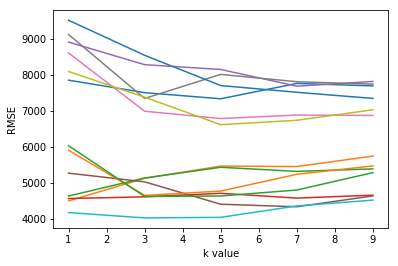

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

# Multivariate Model with fixed k (k = 5)

In [14]:
# We want to find the best features/attributes from the previous model
# So we compute the average RMSE across different `k` values for each feature.
feature_avg_rmse = {}
for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
series_avg_rmse.sort_values()

horsepower           4219.377860
width                4618.910560
curb-weight          4730.075815
highway-mpg          5069.469256
length               5176.394904
city-mpg             5202.409003
wheel-base           5252.392462
compression-rate     7166.073599
bore                 7222.472445
normalized-losses    7624.407151
stroke               8000.240467
peak-rpm             8119.365233
height               8163.346266
dtype: float64

In [15]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [5]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

two_best_features = ['horsepower', 'width']
rmse_val = knn_train_test(two_best_features, 'price', numeric_cars)
k_rmse_results["two best features"] = rmse_val

three_best_features = ['horsepower', 'width', 'curb-weight']
rmse_val = knn_train_test(three_best_features, 'price', numeric_cars)
k_rmse_results["three best features"] = rmse_val

four_best_features = ['horsepower', 'width', 'curb-weight', 'highway-mpg']
rmse_val = knn_train_test(four_best_features, 'price', numeric_cars)
k_rmse_results["four best features"] = rmse_val

five_best_features = ['horsepower', 'width', 'curb-weight' , 'highway-mpg' , 'length']
rmse_val = knn_train_test(five_best_features, 'price', numeric_cars)
k_rmse_results["five best features"] = rmse_val

six_best_features = ['horsepower', 'width', 'curb-weight' , 'highway-mpg' , 'length', 'city-mpg']
rmse_val = knn_train_test(six_best_features, 'price', numeric_cars)
k_rmse_results["six best features"] = rmse_val

k_rmse_results

{'two best features': {5: 3589.3132622073304},
 'three best features': {5: 3305.9401397969677},
 'four best features': {5: 3358.6915801682458},
 'five best features': {5: 3665.5466730458129},
 'six best features': {5: 3628.2611882141268}}

# Multivariate Model with several k values

In [16]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [i for i in range(1, 25)]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

three_best_features = ['horsepower', 'width', 'curb-weight']
rmse_val = knn_train_test(three_best_features, 'price', numeric_cars)
k_rmse_results["three best features"] = rmse_val

four_best_features = ['horsepower', 'width', 'curb-weight', 'highway-mpg']
rmse_val = knn_train_test(four_best_features, 'price', numeric_cars)
k_rmse_results["four best features"] = rmse_val

five_best_features = ['horsepower', 'width', 'curb-weight' , 'highway-mpg' , 'length']
rmse_val = knn_train_test(five_best_features, 'price', numeric_cars)
k_rmse_results["five best features"] = rmse_val

k_rmse_results

{'three best features': {1: 3013.0109985241875,
  2: 2813.2859698259972,
  3: 3171.5852844786741,
  4: 3182.3137417981943,
  5: 3305.9401397969677,
  6: 3522.5068489003761,
  7: 3774.3772094554106,
  8: 3978.9691240211159,
  9: 3992.9236805888809,
  10: 4076.2381473803043,
  11: 4156.3883311318068,
  12: 4201.1071338594802,
  13: 4303.6267686132496,
  14: 4359.6932969897016,
  15: 4371.7711033728683,
  16: 4394.4846551644205,
  17: 4510.3997100574061,
  18: 4584.3109618654862,
  19: 4636.6262047706296,
  20: 4664.4658478668107,
  21: 4724.0966374282734,
  22: 4752.5354841029139,
  23: 4808.7033104521006,
  24: 4858.9452710176065},
 'four best features': {1: 2600.746383728188,
  2: 2725.4325072335123,
  3: 3108.8580314362966,
  4: 3217.3135209486827,
  5: 3358.6915801682458,
  6: 3633.1687033129465,
  7: 3896.1274413966439,
  8: 4002.8383900652543,
  9: 4055.5309369929582,
  10: 4128.6780774154204,
  11: 4249.8272893472677,
  12: 4344.0358982374919,
  13: 4402.9952931661564,
  14: 4424.

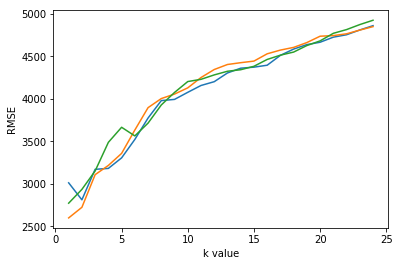

In [17]:
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

# Conclusion
The project shows how the k-nearest neighbor algorithm works in a univariate and a multivariate model. In the univariate model you can see that horsepower seems to be the best attribute to predict the price of the car. On the other hand you also have to consider the number of k neighbors in your model to get a better model performance.

In the multivariate model it is interesting to see that the best outcome (or the lowest rmse) is with four attributes and a k value of 1.